## Multilabel Classification
1. Load Libraries and data
2. Handling NA
3. Data Transformation for checking class imbalance
4. EDA and Class imbalance
5. Train Test Split
6. Handling Class Imbalance with Oversampling
7. Creating Tensorflow Dataset with Augmentation
8. Model Building and Evaluation


### 1. Load Libraries and data

In [1]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Loading Librares
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow.keras.backend as K 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import tensorflow_addons as tfa
import cv2
from skimage.transform import rotate, AffineTransform, warp, resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import warnings

warnings.filterwarnings("ignore")

In [3]:
#Loading data
image_path = '/content/drive/MyDrive/DS_Datas/Multilabel/images/'
labels_path = '/content/drive/MyDrive/DS_Datas/Multilabel/labels.txt'

In [4]:
#checking on number of images
len(os.listdir(image_path))

972

In [5]:
image_path_list = list(os.listdir(image_path))
image_path_list[:5]

['image_539.jpg',
 'image_932.jpg',
 'image_592.jpg',
 'image_866.jpg',
 'image_461.jpg']

#### Creating DataFrame of Images and Labels

In [6]:
image_df = pd.DataFrame(columns=["Image Name", "Image Path"])
for img_name in image_path_list:
    image_df = image_df.append({"Image Name": img_name, "Image Path": image_path+img_name}, ignore_index='True')
image_df.head()

,Image Name,Image Path
0,image_539.jpg,/content/drive/MyDrive/DS_Datas/Multilabel/ima...
1,image_932.jpg,/content/drive/MyDrive/DS_Datas/Multilabel/ima...
2,image_592.jpg,/content/drive/MyDrive/DS_Datas/Multilabel/ima...
3,image_866.jpg,/content/drive/MyDrive/DS_Datas/Multilabel/ima...
4,image_461.jpg,/content/drive/MyDrive/DS_Datas/Multilabel/ima...


In [7]:
#checking length of image_df
len(image_df)

972

In [8]:
#loading labels
labels_df = pd.read_csv(labels_path, sep=" ", header=None)
labels_df.columns = ["Image Name", "Attr1", "Attr2", "Attr3","Attr4"]
labels_df.head()

,Image Name,Attr1,Attr2,Attr3,Attr4
0,image_0.jpg,1.0,NaN,0.0,1.0
1,image_1.jpg,NaN,0.0,0.0,0.0
2,image_2.jpg,1.0,1.0,0.0,0.0
3,image_3.jpg,1.0,1.0,0.0,0.0
4,image_4.jpg,1.0,1.0,0.0,0.0


In [9]:
#checking length of labels_df
len(labels_df)

975

There is a difference in the number of images shown in labels and number of images images. We need to do an inner join between the two dataframes

In [10]:
#merging both the dataframes with inner join
df = image_df.merge(labels_df, how='inner', on="Image Name")
df.head()

,Image Name,Image Path,Attr1,Attr2,Attr3,Attr4
0,image_539.jpg,/content/drive/MyDrive/DS_Datas/Multilabel/ima...,1.0,0.0,0.0,1.0
1,image_932.jpg,/content/drive/MyDrive/DS_Datas/Multilabel/ima...,1.0,1.0,0.0,0.0
2,image_592.jpg,/content/drive/MyDrive/DS_Datas/Multilabel/ima...,1.0,0.0,0.0,0.0
3,image_866.jpg,/content/drive/MyDrive/DS_Datas/Multilabel/ima...,1.0,1.0,0.0,0.0
4,image_461.jpg,/content/drive/MyDrive/DS_Datas/Multilabel/ima...,1.0,0.0,0.0,0.0


In [11]:
#cheking the length
len(df)

972

In [12]:
#getting the attributes names
class_names = list(df.columns[2:])
class_names

['Attr1', 'Attr2', 'Attr3', 'Attr4']

### 2. Handling NA

In [13]:
#lets see how much is NA
df[["Attr1","Attr2","Attr3","Attr4"]].isnull().sum()/len(df)


Attr1    0.082305
Attr2    0.093621
Attr3    0.094650
Attr4    0.094650
dtype: float64

In [14]:
#filling all the Null values with 0 
#because “NA” means that information about the corresponding attribute in that image is not available
#hence we take that the attribute is not present in that image

for attr in class_names:
    df[attr].fillna(0.0, inplace=True)
    
#lets see how much is NA
df[["Attr1","Attr2","Attr3","Attr4"]].isnull().sum()/len(df)

Attr1    0.0
Attr2    0.0
Attr3    0.0
Attr4    0.0
dtype: float64

In [15]:
df.head()

,Image Name,Image Path,Attr1,Attr2,Attr3,Attr4
0,image_539.jpg,/content/drive/MyDrive/DS_Datas/Multilabel/ima...,1.0,0.0,0.0,1.0
1,image_932.jpg,/content/drive/MyDrive/DS_Datas/Multilabel/ima...,1.0,1.0,0.0,0.0
2,image_592.jpg,/content/drive/MyDrive/DS_Datas/Multilabel/ima...,1.0,0.0,0.0,0.0
3,image_866.jpg,/content/drive/MyDrive/DS_Datas/Multilabel/ima...,1.0,1.0,0.0,0.0
4,image_461.jpg,/content/drive/MyDrive/DS_Datas/Multilabel/ima...,1.0,0.0,0.0,0.0


### 3. Data Transformation for checking class imbalance

Adding up one column to check for imbalance

In [16]:
# creating a new column called weighted attr
#we will use weighted attr = 16*attr1 + 8*attr2 + 4*attr3 + 2*attr4
df["weighted attr"] = 16*df["Attr1"] + 8*df["Attr2"] + 4*df["Attr3"] + 2*df["Attr4"]
df.head()

,Image Name,Image Path,Attr1,Attr2,Attr3,Attr4,weighted attr
0,image_539.jpg,/content/drive/MyDrive/DS_Datas/Multilabel/ima...,1.0,0.0,0.0,1.0,18.0
1,image_932.jpg,/content/drive/MyDrive/DS_Datas/Multilabel/ima...,1.0,1.0,0.0,0.0,24.0
2,image_592.jpg,/content/drive/MyDrive/DS_Datas/Multilabel/ima...,1.0,0.0,0.0,0.0,16.0
3,image_866.jpg,/content/drive/MyDrive/DS_Datas/Multilabel/ima...,1.0,1.0,0.0,0.0,24.0
4,image_461.jpg,/content/drive/MyDrive/DS_Datas/Multilabel/ima...,1.0,0.0,0.0,0.0,16.0


### 4. EDA and Class imbalance

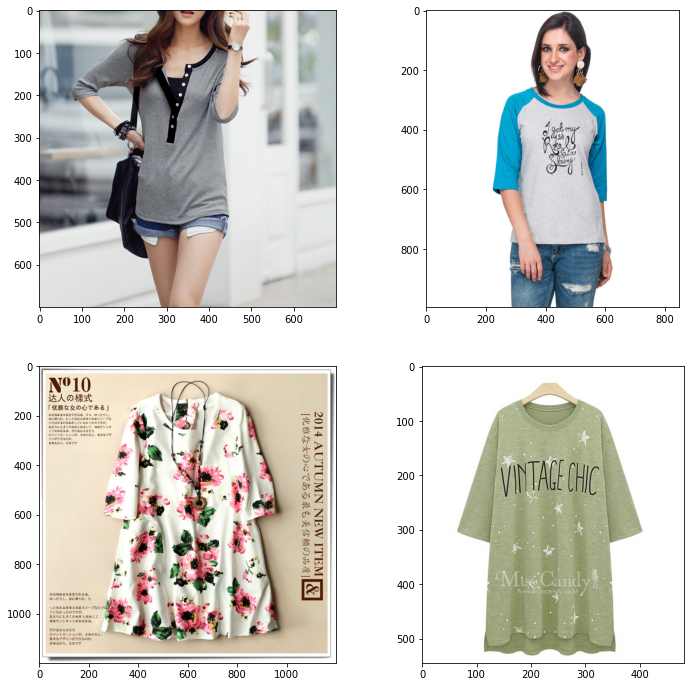

In [17]:
rand_idx=np.random.randint(0,50,4)
rand_idx

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

img = cv2.imread(df.iloc[rand_idx[0]]["Image Path"])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ax[0,0].imshow(img)
img = cv2.imread(df.iloc[rand_idx[1]]["Image Path"])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ax[0,1].imshow(img)
img = cv2.imread(df.iloc[rand_idx[2]]["Image Path"])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ax[1,0].imshow(img)
img = cv2.imread(df.iloc[rand_idx[3]]["Image Path"])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ax[1,1].imshow(img)

In [18]:
img.shape

(545, 481, 3)

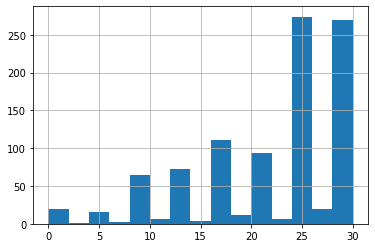

In [19]:
#check for imbalance

df['weighted attr'].hist(bins=np.unique(df['weighted attr']))

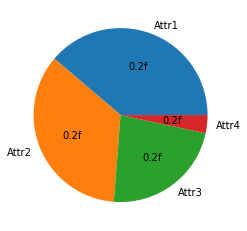

In [20]:
#plotting pie chart for each individual attributes

plt.pie(df[["Attr1","Attr2","Attr3","Attr4"]].sum(), autopct="0.2f", labels=["Attr1","Attr2","Attr3","Attr4"])
plt.show()

### 5. Train Test Split
splitting train and test before handling class imbalance

In [21]:
#creating train test split

train_inds, val_inds = train_test_split(np.array(list(range(df.shape[0]))),test_size=0.2,random_state=7)
train_df = df.iloc[train_inds,:].reset_index(drop=True)
val_df = df.iloc[val_inds,:].reset_index(drop=True)

In [22]:
train_df.head()

,Image Name,Image Path,Attr1,Attr2,Attr3,Attr4,weighted attr
0,image_127.jpg,/content/drive/MyDrive/DS_Datas/Multilabel/ima...,1.0,0.0,0.0,0.0,16.0
1,image_972.jpg,/content/drive/MyDrive/DS_Datas/Multilabel/ima...,1.0,0.0,1.0,0.0,20.0
2,image_294.jpg,/content/drive/MyDrive/DS_Datas/Multilabel/ima...,1.0,0.0,0.0,0.0,16.0
3,image_876.jpg,/content/drive/MyDrive/DS_Datas/Multilabel/ima...,1.0,1.0,1.0,0.0,28.0
4,image_821.jpg,/content/drive/MyDrive/DS_Datas/Multilabel/ima...,1.0,1.0,0.0,0.0,24.0


In [23]:
train_df.isnull().sum()

Image Name       0
Image Path       0
Attr1            0
Attr2            0
Attr3            0
Attr4            0
weighted attr    0
dtype: int64

In [24]:
val_df.isnull().sum()

Image Name       0
Image Path       0
Attr1            0
Attr2            0
Attr3            0
Attr4            0
weighted attr    0
dtype: int64

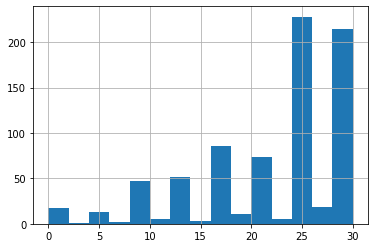

In [25]:
#check for imbalance in training data

train_df['weighted attr'].hist(bins=np.unique(df['weighted attr']))

### 6. Handling Class Imbalance with Oversampling

In [26]:
#creating train_df copy before Oversampling
train_df_orig = train_df.copy()

In [29]:
#creating Augmented imaged and keeping it in a new folder
weight_attr = {}
weight_attr_labels = np.unique(train_df["weighted attr"])

for w in weight_attr_labels:
    weight_attr[w] = np.count_nonzero(train_df['weighted attr']==w)

max_count = np.max(list(weight_attr.values()))

for w in weight_attr_labels:
    gap = max_count - weight_attr[w]
    tmp_df = train_df.iloc[np.random.choice(np.where(train_df['weighted attr']==w)[0],size=gap)].reset_index(drop=True)
    train_df = train_df.append(tmp_df,ignore_index=True)

train_df = train_df.sample(frac=1).reset_index(drop=True)


In [30]:
weight_attr = {}
weight_attr_labels = np.unique(train_df["weighted attr"])

for w in weight_attr_labels:
    weight_attr[w] = np.count_nonzero(train_df['weighted attr']==w)

In [31]:
weight_attr

{0.0: 228,
 2.0: 228,
 4.0: 228,
 6.0: 228,
 8.0: 228,
 10.0: 228,
 12.0: 228,
 14.0: 228,
 16.0: 228,
 18.0: 228,
 20.0: 228,
 22.0: 228,
 24.0: 228,
 26.0: 228,
 28.0: 228,
 30.0: 228}

### 7. Creating Tensorflow Dataset with Augmentation

In [32]:
#setting parameters
H,W = (256,256)
BATCH_SIZE = 32
EPOCHS = 10
CLASSES = len(class_names)

In [52]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, train=True, augmentation=False, preprocessing_fn=None, batch_size=32, oversample=True):
        self.train = train
        self.batch_size = batch_size
        self.H = H
        self.W = W
        self.oversample = oversample

        self.augmentation = augmentation
        self.preprocessing_fn = preprocessing_fn

        self.augmentor = ImageDataGenerator(
                            featurewise_std_normalization = True,
                            rotation_range = 10,
                            width_shift_range=0.5,
                            height_shift_range=0.5,
                            brightness_range = (0.5,0.9),
                            shear_range = 10,
                            zoom_range = [0.2, 0.8],
                            channel_shift_range = 0.5,
                            horizontal_flip=True,
                            rescale = 1/255.0,
                            preprocessing_function=self.preprocessing_fn
                        )
        if self.train:
            if self.oversample:
                self.all_files = train_df
            else:
                self.all_files = train_df_orig
        else:
            self.all_files = val_df
    
    def __len__(self):
        return self.all_files.shape[0]//self.batch_size

    def on_epoch_end(self):
        self.all_files = self.all_files.sample(frac=1).reset_index(drop=True)
    
    def __getitem__(self, idx):
        images = np.array([], dtype=np.float).reshape((0, self.H, self.W, 3))
        labels = np.array([], dtype=np.float).reshape((0,CLASSES))

        for i in range(self.batch_size):
            image = img_to_array(load_img(self.all_files["Image Path"][idx*self.batch_size+i],target_size = (self.H,self.W)))
            y = self.all_files.iloc[idx*self.batch_size+i][class_names].values.astype(np.float32)

            images = np.append(images,np.expand_dims(image,axis=0),axis=0)
            labels = np.append(labels,y.reshape(1,CLASSES),axis=0)
        
        if self.augmentation:
            image_gen = self.augmentor.flow(images, y=labels,batch_size=self.batch_size, shuffle=False)
            return next(image_gen)
        else:
            return images, labels



In [53]:
#creating train and test datasets
train_datagen = DataGenerator(train = True, augmentation = True, preprocessing_fn = preprocess_input, batch_size = BATCH_SIZE)
valid_datagen = DataGenerator(train = False, augmentation = False, preprocessing_fn = preprocess_input, batch_size = BATCH_SIZE)

In [54]:
sample_images = next(iter(train_datagen))

In [55]:
sample_images[0][0].shape

(256, 256, 3)

### 8. Model Building and Evaluation
Base Model

In [56]:
model = Sequential()
model.add(ResNet50(include_top=False,pooling='avg',weights='imagenet',input_shape=(H,W,3)))
model.add(layers.Dense(CLASSES,activation = 'sigmoid'))

#### Model 1
Model training with oversampled data

In [57]:
#loss funtion
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

In [58]:
#taking f1_score as metrics
f1_score = tfa.metrics.F1Score(num_classes=4, threshold=0.5)

In [59]:
model.layers[0].trainable = True
model.compile(optimizer = tf.keras.optimizers.Adam(0.001), 
              loss = loss_fn,
              metrics = [f1_score,'acc'])

In [60]:
history1 = model.fit(train_datagen, epochs = EPOCHS, verbose = 1, validation_data = valid_datagen, shuffle = True)

Epoch 1/10
114/114 [==============================] - 184s 2s/step - loss: 3.5081 - f1_score: 0.6650 - acc: 0.4504 - val_loss: 33.6142 - val_f1_score: 0.6237 - val_acc: 0.7812
Epoch 2/10
114/114 [==============================] - 154s 1s/step - loss: 3.2823 - f1_score: 0.6667 - acc: 0.5625 - val_loss: 120.1852 - val_f1_score: 0.6249 - val_acc: 0.7812
Epoch 3/10
114/114 [==============================] - 152s 1s/step - loss: 3.4146 - f1_score: 0.6667 - acc: 0.5625 - val_loss: 29.4801 - val_f1_score: 0.6228 - val_acc: 0.7812
Epoch 4/10
114/114 [==============================] - 151s 1s/step - loss: 3.5297 - f1_score: 0.6667 - acc: 0.5625 - val_loss: 24.9438 - val_f1_score: 0.6229 - val_acc: 0.7760
Epoch 5/10
114/114 [==============================] - 151s 1s/step - loss: 3.9369 - f1_score: 0.6667 - acc: 0.5625 - val_loss: 6.1151 - val_f1_score: 0.6260 - val_acc: 0.7812
Epoch 6/10
114/114 [==============================] - 151s 1s/step - loss: 3.6906 - f1_score: 0.6667 - acc: 0.5625 - val

Model Evaluation first model

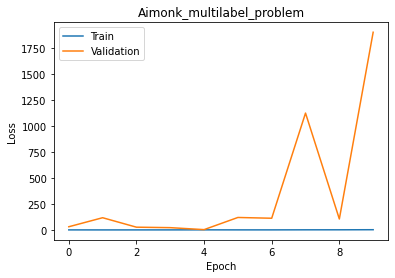

In [61]:
#Evaluating first model
# "Loss"
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Aimonk_multilabel_problem')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Model 2
Model with oversampled data

In [62]:
#changing loss function
def loss_sigmoid_fn(y_true, y_pred):
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=y_pred, labels=tf.cast(y_true,tf.float32))
    loss = tf.reduce_mean(tf.reduce_sum(cross_entropy, axis=1))
    return loss

In [63]:
model.layers[0].trainable = True
model.compile(optimizer = tf.keras.optimizers.Adam(0.001), 
              loss = loss_sigmoid_fn,
              metrics = [f1_score,'acc'])

In [64]:
history2 = model.fit(train_datagen, epochs = 10, verbose = 1, validation_data = valid_datagen, shuffle = True)

Epoch 1/10
114/114 [==============================] - 160s 1s/step - loss: 3.2530 - f1_score: 0.6672 - acc: 0.5625 - val_loss: 3.2010 - val_f1_score: 0.6220 - val_acc: 0.7760
Epoch 2/10
114/114 [==============================] - 156s 1s/step - loss: 3.2530 - f1_score: 0.6667 - acc: 0.5625 - val_loss: 3.1958 - val_f1_score: 0.6228 - val_acc: 0.7812
Epoch 3/10
114/114 [==============================] - 155s 1s/step - loss: 3.2530 - f1_score: 0.6667 - acc: 0.5625 - val_loss: 3.1905 - val_f1_score: 0.6237 - val_acc: 0.7865
Epoch 4/10
114/114 [==============================] - 156s 1s/step - loss: 3.2530 - f1_score: 0.6667 - acc: 0.5625 - val_loss: 3.1905 - val_f1_score: 0.6243 - val_acc: 0.7760
Epoch 5/10
114/114 [==============================] - 160s 1s/step - loss: 3.2530 - f1_score: 0.6667 - acc: 0.5625 - val_loss: 3.2062 - val_f1_score: 0.6194 - val_acc: 0.7760
Epoch 6/10
114/114 [==============================] - 154s 1s/step - loss: 3.2530 - f1_score: 0.6667 - acc: 0.5625 - val_loss

Model Evaluation for second model

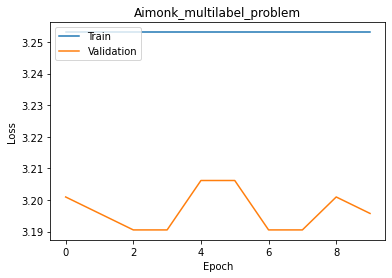

In [65]:
# "Loss"
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Aimonk_multilabel_problem')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Model 3
Without using oversampling and using class weights with loss function as sigmoid loss

In [66]:
# custom loss funtion
#Calculating Class weights
pos_weights = {}
neg_weights = {}
for i,c in enumerate(class_names):
    pos_weights[i] = train_df_orig.shape[0]/(2*np.count_nonzero(train_df[c]==1))
    neg_weights[i] = train_df_orig.shape[0]/(2*np.count_nonzero(train_df[c]==0))
print(pos_weights)
print(neg_weights)


{0: 0.21299342105263158, 1: 0.21299342105263158, 2: 0.21299342105263158, 3: 0.21299342105263158}
{0: 0.21299342105263158, 1: 0.21299342105263158, 2: 0.21299342105263158, 3: 0.21299342105263158}


In [ ]:
#creating train and test datasets
train_datagen = DataGenerator(train = True, augmentation = False, preprocessing_fn = preprocess_input, batch_size = BATCH_SIZE, oversample=False)
valid_datagen = DataGenerator(train = False, augmentation = False, preprocessing_fn = preprocess_input, batch_size = BATCH_SIZE)

In [65]:
model.layers[0].trainable = True
model.compile(optimizer = tf.keras.optimizers.Adam(0.001), 
              loss = loss_sigmoid_fn,
              metrics=[f1_score,'acc'])

In [66]:
history3 = model.fit(train_datagen, epochs = 10, verbose = 1, 
                     validation_data = valid_datagen, 
                     class_weight=pos_weights,
                     shuffle = True)

Epoch 1/10
24/24 [==============================] - 27s 898ms/step - loss: 1.8528 - f1_score: 0.3571 - acc: 0.2630 - val_loss: 2.9765 - val_f1_score: 0.5034 - val_acc: 0.2396
Epoch 2/10
24/24 [==============================] - 20s 824ms/step - loss: 1.8099 - f1_score: 0.3829 - acc: 0.4115 - val_loss: 3.0257 - val_f1_score: 0.6043 - val_acc: 0.3177
Epoch 3/10
24/24 [==============================] - 20s 831ms/step - loss: 1.7711 - f1_score: 0.4845 - acc: 0.8229 - val_loss: 2.8492 - val_f1_score: 0.5475 - val_acc: 0.6719
Epoch 4/10
24/24 [==============================] - 20s 832ms/step - loss: 1.7410 - f1_score: 0.5521 - acc: 0.8398 - val_loss: 2.9119 - val_f1_score: 0.5770 - val_acc: 0.5417
Epoch 5/10
24/24 [==============================] - 20s 834ms/step - loss: 1.7438 - f1_score: 0.5431 - acc: 0.8411 - val_loss: 2.8594 - val_f1_score: 0.5741 - val_acc: 0.7812
Epoch 6/10
24/24 [==============================] - 20s 832ms/step - loss: 1.7129 - f1_score: 0.5494 - acc: 0.8398 - val_loss

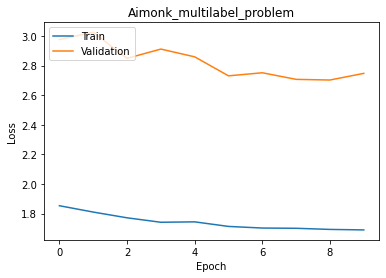

In [67]:
# "Loss"
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Aimonk_multilabel_problem')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Model 4
Without using oversampling and using class weights with loss function as CategoricalCrossentropy

In [68]:
model.layers[0].trainable = True
model.compile(optimizer = tf.keras.optimizers.Adam(0.001), 
              loss = loss_fn,
              metrics=[f1_score,'acc'])

In [69]:
history4 = model.fit(train_datagen, epochs = 10, verbose = 1, 
                     validation_data = valid_datagen, 
                     class_weight=pos_weights,
                     shuffle = True)

Epoch 1/10
24/24 [==============================] - 27s 891ms/step - loss: 24.9143 - f1_score: 0.5696 - acc: 0.8242 - val_loss: 17.8116 - val_f1_score: 0.6395 - val_acc: 0.7812
Epoch 2/10
24/24 [==============================] - 20s 832ms/step - loss: 18.4593 - f1_score: 0.5678 - acc: 0.7669 - val_loss: 14.9012 - val_f1_score: 0.6237 - val_acc: 0.7812
Epoch 3/10
24/24 [==============================] - 20s 832ms/step - loss: 19.7030 - f1_score: 0.5989 - acc: 0.8047 - val_loss: 3.7085 - val_f1_score: 0.6214 - val_acc: 0.7812
Epoch 4/10
24/24 [==============================] - 20s 819ms/step - loss: 22.0369 - f1_score: 0.6289 - acc: 0.8372 - val_loss: 2.7591 - val_f1_score: 0.6208 - val_acc: 0.7760
Epoch 5/10
24/24 [==============================] - 20s 823ms/step - loss: 22.8046 - f1_score: 0.6304 - acc: 0.8424 - val_loss: 6.5077 - val_f1_score: 0.6254 - val_acc: 0.7865
Epoch 6/10
24/24 [==============================] - 20s 827ms/step - loss: 23.0554 - f1_score: 0.6290 - acc: 0.8438 - 

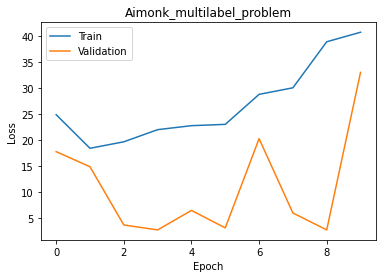

In [71]:
# "Loss"
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Aimonk_multilabel_problem')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()